# Semi-Supervised Learning

## Load Libraries and Data

In [1]:
import warnings
import numpy as np
import pandas as pd
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator, FixedFormatter
import seaborn as sns

# Suppress matplotlib deprecation warnings
warnings.filterwarnings('ignore')

# Make this notebook's output stable across runs
random_state = 1000
np.random.seed(random_state)

# Plot formatting
%matplotlib inline
sns.set()
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [2]:
# Load a dataset of handwritten digits
# This dataset is similar to MNIST but smaller (fewer instances and smaller images)
X_digits, y_digits = load_digits(return_X_y=True) 
X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits, 
                                                    random_state=random_state) 

X_train.shape

(1347, 64)

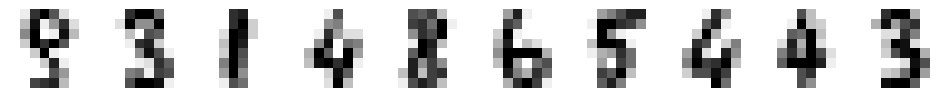

In [3]:
# Visualize the training data
images = 10
plt.subplots(figsize=(12, 3))
for i in range(images):
    ax = plt.subplot(1, 10, i + 1)
    plt.axis('off')
    ax.imshow(X_train[i, :].reshape(8, 8), cmap=plt.cm.gray_r)

plt.show()

## Performance with 50 labeled training instances

### Labeling Training Instances at Random

In [4]:
# Suppose we label 50 training instances at random
n_labeled = 50
log_reg = LogisticRegression(max_iter=1000, random_state=random_state)
log_reg.fit(X_train[:n_labeled], y_train[:n_labeled],) 

# Fit to the test data
log_reg.score(X_test, y_test) 

0.7844444444444445

### Labeling Representative Training Instances

In [5]:
# Create 50 clusters and select the digits that are the closest to
# the centroid of each cluster
k = 50
kmeans = KMeans(n_clusters=k, random_state=random_state)
X_digits_dist = kmeans.fit_transform(X_train)
representative_digit_idx = np.argmin(X_digits_dist, axis=0)
X_representative_digits = X_train[representative_digit_idx]

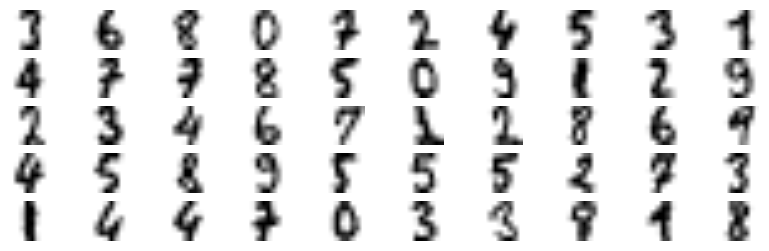

In [6]:
# Display the representative images
plt.figure(figsize=(10, 3))
for index, X_representative_digit in enumerate(X_representative_digits):
    plt.subplot(k // 10, 10, index + 1)
    plt.imshow(X_representative_digit.reshape(8, 8), 
               cmap='binary', interpolation='bilinear')
    plt.axis('off')

plt.show()

In [7]:
y_representative_digits = np.array([
    3, 6, 8, 0, 7, 2, 4, 5, 3, 1,
    4, 7, 7, 8, 5, 0, 9, 1, 2, 9,
    2, 3, 4, 6, 7, 1, 2, 8, 6, 9,
    4, 5, 8, 9, 5, 5, 5, 2, 7, 3,
    1, 4, 4, 7, 0, 3, 3, 8, 1, 8
])

In [8]:
# Fit to the representative digits and evaluate
log_reg = LogisticRegression(max_iter=1000, random_state=random_state)
log_reg.fit(X_representative_digits, y_representative_digits)
log_reg.score(X_test, y_test)

0.9244444444444444

## Label Propagation

### Propagating Labels to Entire Clusters

In [9]:
# Propagate the labels to the entire clusters
y_train_propagated = np.empty(len(X_train), dtype=np.int32)
for i in range(k):
    y_train_propagated[kmeans.labels_==i] = y_representative_digits[i]

In [10]:
# Fit to the representative digits and the propagated labels, then evaluate
log_reg = LogisticRegression(max_iter=10000, random_state=random_state)
log_reg.fit(X_train, y_train_propagated)

LogisticRegression(max_iter=10000, random_state=1000)

In [11]:
log_reg.score(X_test, y_test)

0.9355555555555556

### Propagating Labels to the Closet Instances Within Clusters

In [12]:
percentile_closest = 50

X_cluster_dist = X_digits_dist[np.arange(len(X_train)), kmeans.labels_]
for i in range(k):
    in_cluster = (kmeans.labels_ == i)
    cluster_dist = X_cluster_dist[in_cluster]
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)
    above_cutoff = (X_cluster_dist > cutoff_distance)
    X_cluster_dist[in_cluster & above_cutoff] = -1
    
partially_propagated = (X_cluster_dist != -1)
X_train_partially_propagated = X_train[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]

In [13]:
log_reg = LogisticRegression(max_iter=10000, random_state=random_state)
log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)

LogisticRegression(max_iter=10000, random_state=1000)

In [14]:
log_reg.score(X_test, y_test)

0.9288888888888889

## Comparison: Using the Full Training Set

In [15]:
log_reg = LogisticRegression(max_iter=10000, random_state=random_state)
log_reg.fit(X_train, y_train)
log_reg.score(X_test, y_test)

0.9666666666666667

## Results

| Method                                                      | Test Accuracy |
| ----------------------------------------------------------- | ------------- |
| Label 50 random instances                                   | 78.4%         |
| Label 50 representative instances determined via clustering | 92.4%         |
| Propagate labels to clusters                                | 93.6%         |
| Propagate labels to closest points in clusters              | 92.9%         |

In each case, we require labels for 50/1,347 (3.7%) of the instances.

Training on all 1,347 labeled instances yields a test accuracy of 96.7%.